In [6]:
#Torch
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

# Ready to use continual learning benchmarks
from avalanche.benchmarks.datasets import MNIST, FashionMNIST, KMNIST, EMNIST, QMNIST, FakeData, CocoCaptions, CocoDetection, LSUN, ImageNet, CIFAR10, CIFAR100, STL10, SVHN, PhotoTour, SBU, Flickr8k, Flickr30k, VOCDetection, VOCSegmentation, Cityscapes, SBDataset, USPS, Kinetics400, HMDB51, UCF101, CelebA, TinyImagenet, CUB200, OpenLORIS

# Models
import avalanche
from avalanche.models import SimpleCNN
from avalanche.models import SimpleMLP
from avalanche.models import MTSimpleMLP
from avalanche.models import SimpleMLP_TinyImageNet
from avalanche.models import MobilenetV1

# Build-in strategies
from avalanche.training.strategies import Naive, CWRStar, Replay, GDumb, LwF, GEM, AGEM, EWC

# Base strategy classes
from avalanche.training.strategies import BaseStrategy
from avalanche.training.plugins import StrategyPlugin
from typing import Optional, Sequence, Union
from avalanche.benchmarks import Experience

# Logger
from avalanche.logging import InteractiveLogger

# Evaluation
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import StreamAccuracy
from avalanche.evaluation.plot_utils import learning_curves_plot

from avalanche.training.strategies import BaseStrategy
from typing import Optional, Sequence, Union
from avalanche.benchmarks import Experience

from avalanche.training.plugins import ReplayPlugin, EWCPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics
from avalanche.training.plugins import EvaluationPlugin

from avalanche.benchmarks.classic import SplitMNIST, SplitCIFAR10
from avalanche.logging import InteractiveLogger

In [26]:
from avalanche.models.dynamic_modules import IncrementalClassifier
from avalanche.models.dynamic_modules import MultiHeadClassifier
from avalanche.models.dynamic_modules import MultiTaskModule
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
benchmark = SplitCIFAR10(n_experiences=5, seed=101, return_task_id=True)

# choose some metrics and evaluation method
interactive_logger = InteractiveLogger()

# main_metric = StreamAccuracy()
eval_plugin = EvaluationPlugin(
    StreamAccuracy(),
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
#     loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
#     timing_metrics(epoch=True),
    forgetting_metrics(experience=True, stream=True),
#     cpu_usage_metrics(experience=True),
#     confusion_matrix_metrics(num_classes=split_mnist.n_classes, save_image=False, stream=True),
#     disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=interactive_logger
)

model = SimpleCNN()
print(model)
# model = IncrementalClassifier(model.classifier[0].in_features, initial_out_features=2)
model.classifier = IncrementalClassifier(model.classifier[0].in_features, initial_out_features=2)
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropyLoss()

# EWC Training
# Choose a CL strategy
cl_strategy = EWC(
    model=model, optimizer=optimizer, criterion=criterion,
    train_mb_size=4096, train_epochs=1, eval_mb_size=4096, device=device,
    evaluator=eval_plugin,
    ewc_lambda=10)

for experience in benchmark.train_stream:
    print(experience.future_classes)
    print(model)
    cl_strategy.train(experience)
#     cl_strategy.eval(benchmark.test_stream)
cl_strategy.eval(benchmark.test_stream)

Files already downloaded and verified
Files already downloaded and verified
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): AdaptiveMaxPool2d(output_size=1)
    (15): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=10, bias

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]
> Eval on experience 2 (Task 2) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002 = 0.4620
-- Starting eval on experience 3 (Task 3) from test stream --
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]
> Eval on experience 3 (Task 3) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003 = 0.4815
-- Starting eval on experience 4 (Task 4) from test stream --
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]
> Eval on experience 4 (Task 4) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task004/Exp004 = 0.6125
-- >> End of eval phase << --
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5725
	Top1_Acc_Stream/eval_phase/test_stream/Task001 = 0.5695
	Top1_Acc_Stream/eval_phase/test_stream/Task002 = 0.4620
	Top1_Acc_Stream/eval_phase/tes

{'Top1_Acc_MB/train_phase/train_stream/Task000': 0.5342920353982301,
 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.5207,
 'Top1_Acc_MB/train_phase/train_stream/Task001': 0.5547566371681416,
 'Top1_Acc_Epoch/train_phase/train_stream/Task001': 0.4883,
 'Top1_Acc_MB/train_phase/train_stream/Task002': 0.5237831858407079,
 'Top1_Acc_Epoch/train_phase/train_stream/Task002': 0.5049,
 'Top1_Acc_MB/train_phase/train_stream/Task003': 0.5027654867256637,
 'Top1_Acc_Epoch/train_phase/train_stream/Task003': 0.4983,
 'Top1_Acc_MB/train_phase/train_stream/Task004': 0.49889380530973454,
 'Top1_Acc_Epoch/train_phase/train_stream/Task004': 0.4912,
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.5725,
 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.5695,
 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002': 0.462,
 'Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003': 0.4815,
 'Top1_Acc_Exp/eval_phase/test_stream/Task004/Exp004': 0.6125,
 'Top1_Acc_Stream/eval_phase/test_stream

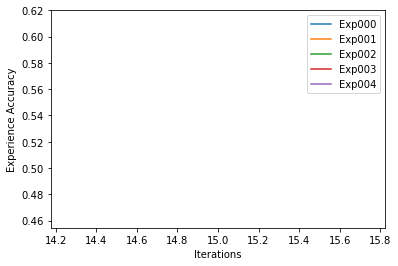

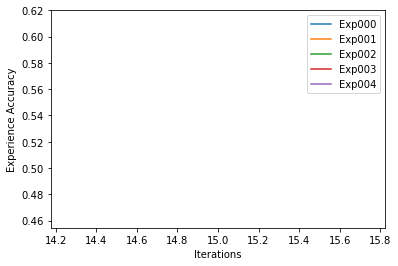

In [28]:
# since no training and evaluation has been performed, this will return an empty dict.
learning_curves_plot(eval_plugin.get_all_metrics())